In [27]:
import numpy as np
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext.data
import random
import matplotlib.pyplot as matpy

torch.cuda.manual_seed(1)




In [28]:
#matpy.plot?
#x= [1,2,3,4,5]
#y=[1,2,2,4,5]
#matpy.plot(range(len(x)), y, color='green', linestyle='dashed', marker='o',
#         markerfacecolor='blue', markersize=12)


In [29]:
class RelationClassifier(nn.Module):
    # Module which implements the model
    def __init__ (self, input_dim, hidden_dim, output_dim):
        nn.Module.__init__(self)
        
        self.linear_input = nn.Linear(input_dim,hidden_dim)
        self.linear_hidden = nn.Linear(hidden_dim,output_dim)
        
    def forward(self, input_vector):
        
        hidden_layer = self.linear_input(input_vector)
        hidden_units = F.tanh(hidden_layer)
        output = self.linear_hidden(hidden_units)
        
        return(F.log_softmax(output).view(1,-1))


In [10]:
dict_Vectors = {}
with open("/home/achingacham/Model/GRID_data/Evaluation_Datasets/BLESS/preTrainedVectors.txt") as inputFile:
    content = inputFile.readlines()
    for index,line in enumerate(content):
        values = line.split()
        if len(values) == 401:
            if values[0] in dict_Vectors.keys():
                #print(values[0] + " Exists! @ " + str(index))
                pass
            else:
                dict_Vectors[values[0]] =  np.array(values[1:],float)
        else:
            pass
            #print(index,len(values),values[0])
            
#print(type(dict_Vectors['radio'][0]))


In [30]:
#Make input vectors

def make_input_vector(target,relata):
    
    word1 = target.lower()
    word2 = relata.lower()
    
    #collect the respective vectors for word 1 & 2
    vector_1 = np.ndarray.astype(dict_Vectors[word1],float)
    vector_2 = np.ndarray.astype(dict_Vectors[word2],float)
    
    #Combine these two vectors to form a single vector
    
    relation_vector = vector_1 - vector_2    
    tensor = torch.cuda.FloatTensor(relation_vector)
    
    
    return(tensor)


In [7]:
#SPlit dataset to avoid lexical memorization

with open("/home/achingacham/Model/GRID_data/Evaluation_Datasets/BLESS/UniqueTuples") as inputFile:
    content = inputFile.readlines()
    total_data = len(content) 
    #60% train, 10% dev, 30% test
    random.shuffle(content)
    train_data  = content[0:int(total_data*.6)]
    dev_data    = content[int(total_data*.6):int(total_data*.7)]
    test_data   = content[int(total_data*.7):]
    
    

In [32]:
#MODEL

INPUT_DIM = 400
HIDDEN_UNIT = 400
OUTPUT_LABEL = 8

model = RelationClassifier(INPUT_DIM, HIDDEN_UNIT, OUTPUT_LABEL)
loss = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.09)
    
if torch.cuda.is_available:
    model.cuda()

/home/achingacham/.local/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


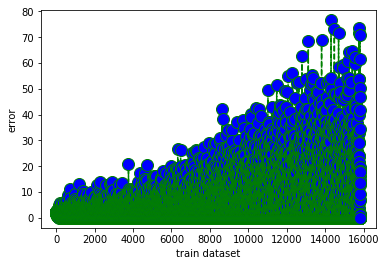

In [33]:
#TRAINING
labels_to_ix = {}

Train_Error_cost = []

for entry in train_data:
    
    input_words = entry.split()

    concept = input_words[0]
    relata = input_words[1]   
    relation = input_words[2]
    
    model.zero_grad()
    
    if relation not in labels_to_ix:
        labels_to_ix[relation] = len(labels_to_ix)
    
    
    input_vector = autograd.Variable(make_input_vector(concept,relata))
    target_label = autograd.Variable(torch.cuda.LongTensor([labels_to_ix[relation]]))
    
    log_prob = model(input_vector)
    cost = loss(log_prob,target_label)
    
    Train_Error_cost.append(cost.data.tolist())
    
    #Make it mini batches
    #print(cost.data.tolist())
    
    cost.backward()
    optimizer.step()

    
matpy.plot(range(len(train_data)),Train_Error_cost,color='green', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=12)
matpy.ylabel("error")
matpy.xlabel("train dataset")
matpy.show()

In [35]:
#VALIDATION

count = 0
Dev_Error_cost = []

for entry in dev_data:
    input_words = entry.split()
    

    concept = input_words[0]
    relata = input_words[1]   
    relation = input_words[2]
    
    input_vector = autograd.Variable(make_input_vector(concept,relata))
    target_label = autograd.Variable(torch.cuda.LongTensor([labels_to_ix[relation]]))
    
    log_prob = model(input_vector)
    
    predict_label = log_prob.max(1)[1]
    
    dev_cost = loss(log_prob,target_label)

    Dev_Error_cost.append(dev_cost.data.tolist())

    if(str(predict_label.data) == str(target_label.data)):     
        count += 1

/home/achingacham/.local/lib/python3.5/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


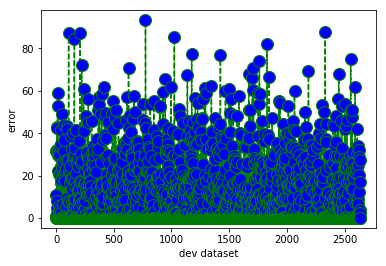

Accuracy 58.75663381349507


In [36]:
#print("Error for Dev set", Dev_Error_cost)

matpy.plot(range(len(dev_data)),Dev_Error_cost, color='green', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=12)
matpy.ylabel("error")
matpy.xlabel("dev dataset")
matpy.show()

print("Accuracy",(count/len(dev_data))*100)


range(0, 2638)
